# Introduction

Unsurprisingly, computation speed plays a huge role in data science competitions and machine learning, especially when the dataset is large and your models are Deep Neural Networks like EfficientNet that contains millions of nodes that needs to be trained individually.

Model training is like catching fish in a vast ocean using a fishing net. The bigger your net, the more fish you can catch. Similar to your computer's compute capability, the better your computer specs are the more training it can do. Unfortunately, not everyone has a monster machine or a server that is capable of using TPU-powered training. Therefore the best closest thing to TPUs would be GPUs in your own local machine, so why not make the best out of it by milking your GPU's juice to its last drop.

Imagine that your fishing net's size represents the virtual memory (VRAM) of your GPU. Using the same analogy as earlier, the GPU's VRAM limits the amount of data it can process at one given moment. This means that in terms of training Neural Networks, your batch size is restricted by the GPU's VRAM which makes VRAM specs very important for Deep Learning applications. 

Noisy datasets like the ones in this competition requires a larger batch size since the bigger batch sizes tends to reduce biasness per batch of training data. Therefore, to enable a larger batch size, a higher VRAM limit would be essential and to achieve that we will need to either get a GPU with a higher VRAM or we incorporate multiple GPUs into our training.

In this notebook, we attempt to use a multi-gpu setup utilizing Tensorflow coupled with tf.data.Dataset pipeline and the computationally-efficient TFRecords file streaming system for blazing fast GPU-modelling (in comparison to Keras and raw image files).

# Seed EVERYTHING!

To start things off, we will need to fix our random state seed for reproducability. 

This step will make our optimization experimentations more effective with each iteration.

In [1]:
import tensorflow as tf
import os
import numpy as np
import random

SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

    print("Random seed initialized.")

set_global_determinism(seed=SEED)

Random seed initialized.


# Environment Setup

We will be using a two-unit GPU system for our modelling. Setting the memory growth for both GPUs to enable synchronization.

Applying mixed-precision halves our data points from `float32` to `float16` byte size, using less memory during computations. (Do note that only GPUs after RTX 20xx series will be able to do this.)

As for our distribution strategy, we will be using the standard Mirrored Strategy. The default reduction method, Nvidia Collective Communications Library (NCCL) All Reduce is not available in Windows environments therefore we will use the Hierarchical All-Reduce instead.



In [2]:
import pandas as pd
import json, cv2, re, math
import seaborn as sns
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

from sklearn.model_selection import KFold
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAvgPool2D, Input, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4, EfficientNetB5
from tensorflow.keras.applications import ResNet50V2, Xception, InceptionV3, DenseNet201
from tensorflow.keras.mixed_precision import Policy, set_global_policy, LossScaleOptimizer
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

import albumentations as A
from functools import partial

# Filter all Tensorflow logs except FATAL errors
tf.get_logger().setLevel('FATAL') #DEBUG,ERROR,FATAL,INFO,WARN

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Mixed Precision
set_global_policy(Policy('mixed_float16'))

# Mirrored Strategy
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1"], 
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
)

# Initialize paths
PATH = "E:\Cassava_images"
AUTOTUNE = tf.data.experimental.AUTOTUNE
FILENAMES = tf.io.gfile.glob(PATH + "/Base_14fold/*.tfrec")
ns_weights = 'D:\Datasets/noisy_student/noisy_student_efficientnet_b4.h5'

for x in device_lib.list_local_devices():
    if x.device_type == 'GPU':
        print(x.physical_device_desc)

device: 0, name: GeForce RTX 3060, pci bus id: 0000:04:00.0, compute capability: 8.6
device: 1, name: GeForce RTX 3060, pci bus id: 0000:0a:00.0, compute capability: 8.6


# Data preprocessing

All our dataset has be preprocessed in this following notebook, here.

Preprocessing steps:

1. Merge data from both 2019 and 2020 competitions
2. Drop duplicates using compounded image-hashing
3. Resized images to 600 by 600 pixel
4. Performed stratified split by labels
5. Converted data into TFREC shards of equal distribution

In [3]:
# Initialize variables
REPLICAS = strategy.num_replicas_in_sync
BATCH_SIZE_PER_REPLICA = 8
BUFFER_SIZE = 1024
IMAGE_SIZE = [512, 512]
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * REPLICAS
print('Number of replicas:', REPLICAS)
print('Global Batch Size:', GLOBAL_BATCH_SIZE)
print('Number of shards:', len(FILENAMES))

Number of replicas: 2
Global Batch Size: 16
Number of shards: 14


# tf.data.Dataset Input functions

TFRecord shards are read into our data pipeline in streams making it memory efficient.

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=IMAGE_SIZE, method='nearest')
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [5]:
def read_tfrecord(example, labeled):
    labeled_map = {"image": tf.io.FixedLenFeature([], tf.string),
                    "target": tf.io.FixedLenFeature([], tf.int64)}
    unlabeled_map = {"image": tf.io.FixedLenFeature([], tf.string)}

    tfrecord_format = (labeled_map if labeled else unlabeled_map)
    
    example = tf.io.parse_single_example(serialized=example,
                                  features=tfrecord_format)

    image = decode_image(example["image"])

    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    return image

In [6]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled),
        num_parallel_calls=AUTOTUNE
        )
    return dataset

In [7]:
def one_hot(image, label, CLASSES=5):
    return image, tf.one_hot(indices=label, 
                             depth=CLASSES,
                             dtype=tf.float32)

In [8]:
def count_data_items(filenames):
    """Obtaining total number of images in dataset from
    the tfrecord shards."""
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1))
         for filename in filenames]
    return np.sum(n)

# Augmentation

Augmentation is a generalization technique that creates copies of our image data but with difference such as rotation, cropping and many more.

## Training set

For our training set, we integrated Albumentations augmentation functions together with tf.data.Dataset pipeline which enables more complex augmentation techniques.

CutMix augmentation was also employed to further improve generalization.

Do note that we did not normalize or implemented any image quality augmentations like HueSaturationValue or RandomContrast to the data, apparently these types of augmentations reduces model accuracy.

In [9]:
def train_transform(image):
    transforms = A.Compose([
        A.RandomCrop(*IMAGE_SIZE),
        A.ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=45,
            interpolation=cv2.INTER_CUBIC
        ),
        # A.HueSaturationValue(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.CoarseDropout(),
        A.Cutout(),
    ], p=1)  

    aug_image = transforms(image=image)['image']
    aug_image = tf.cast(x=aug_image, dtype=tf.float32)
    return aug_image

def train_augment(image, label):
    aug_image = tf.numpy_function(func=train_transform, inp=[image], Tout=tf.float32)
    return aug_image, label

In [10]:
def cutmix(image, label, PROBABILITY=0.5, CLASSES=5):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]

    imgs = []; labs = []
    for j in range(GLOBAL_BATCH_SIZE):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,GLOBAL_BATCH_SIZE),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    image2 = tf.reshape(tf.stack(imgs),(GLOBAL_BATCH_SIZE,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(GLOBAL_BATCH_SIZE,CLASSES))
    return image2,label2

Over here, we purposefully placed multiple batch and unbatch in the sequence to remove any order within our data.

Tensorflow's SparseCategoricalCrossentropy does not have a label_smoothing parameter, therefore One Hot encoding was included due to the need to implement label smoothing for our loss metric.

Including a cache() step in our data flow utilizes our CPU to prefetch batches of data ahead of time into our RAMs, but due to the large data size, we will not be able to implement this.

In [11]:
def get_train_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.map(partial(train_augment), num_parallel_calls=AUTOTUNE) 
    dataset = dataset.repeat()
    dataset = dataset.map(one_hot, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    dataset = dataset.map(cutmix, num_parallel_calls=AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

## Validation set

For our validation set, it is best to keep them unchanged or at most resizing or center cropping should be done. This is so that we do not introduce any biasness into our validation, in an attempt to mimic an unknown test set.

Cache can be applied here due to the smaller data size.

In [12]:
"""repeat() required to increase validation_steps"""
def get_val_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.map(one_hot, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

## Test set

Unlike the training and validation sets, we have set up the data flow to enable Test-time Augmentation (TTA).

In [13]:
def test_transform(image):
    transforms = A.Compose([
        A.CenterCrop(*IMAGE_SIZE),
        A.Resize(*IMAGE_SIZE, interpolation=cv2.INTER_CUBIC)
    ])
    aug_image = transforms(image=image)['image']
    aug_image = tf.cast(x=aug_image, dtype=tf.float32)
    return aug_image

def test_augment(image, label):
    aug_image = tf.numpy_function(func=val_transform, inp=[image], Tout=tf.float32)
    return aug_image, label

def get_test_dataset(filenames, labeled=False):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.map(partial(test_augment))
    dataset = dataset.repeat()
    dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

## Augment Visualization

In [14]:
def display_image(dataset):
    dataset = dataset.unbatch().batch(16)
    images, labels = next(iter(dataset))
    col = 4; row = 4
    plt.figure(figsize=(10, 10))
    for i in range(row*col):
        plt.subplot(row, col, i+1)
        plt.axis('off')
        image = tf.image.convert_image_dtype(images[i]/255.0, 'uint8')
        plt.imshow(image)

    plt.tight_layout()
    plt.show()

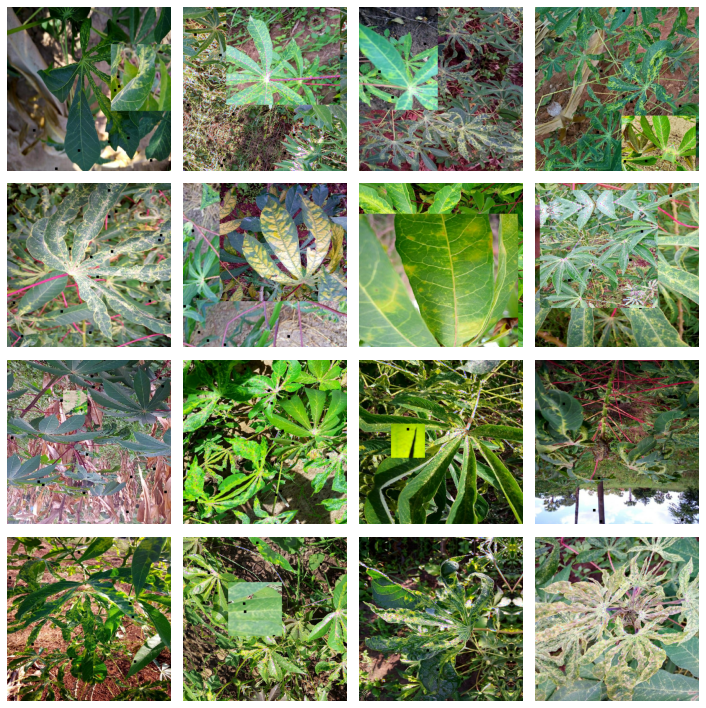

In [15]:
train_dataset = get_train_dataset(FILENAMES)
display_image(train_dataset)

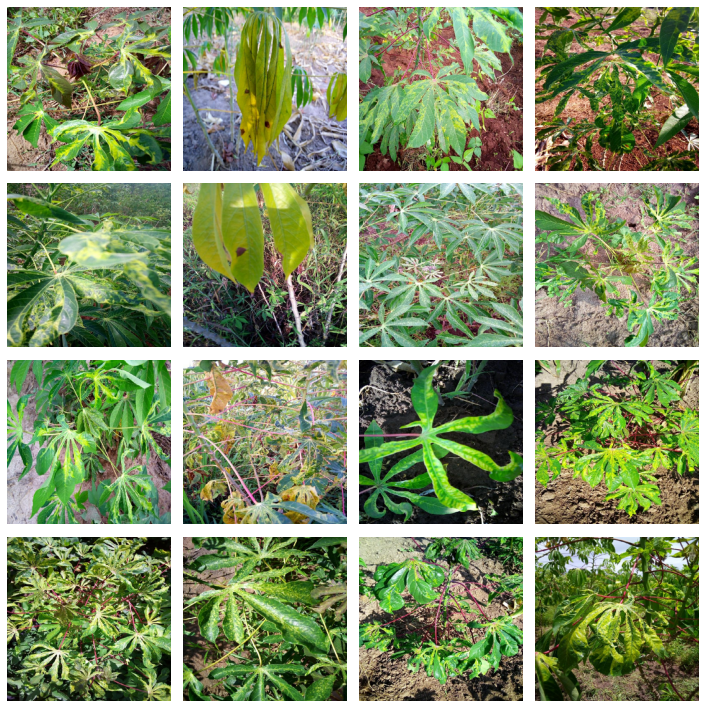

In [16]:
val_dataset = get_val_dataset(FILENAMES)
display_image(val_dataset)

# Model training

We managed the experiments using an Excel spreadsheet to keep track of the model performance after each iteration.

### Learning Rate Schedules

Cosine Annealing schedules are learning schedules that follows a half cosine curve. The primary characteristics of this type of learning curve is that it has three general phases in its learning rate reduction. Basically, the curve has slows down its decay at the start and end of the training while speeding up in between.

Warm restarts are when the learning rate is suddenly increased in a step or a gradient-wise. These spikes in learning rate helps the model "free" itself from getting stuck in local minimas which tends to increase model loss. Unlike to warm restarts, warm starts are usually placed during the first few epochs. 

As we will be using a pretrained model which comes with pretrained weights, we would want to use these so-called savepoints/checkpoints as best we can to start our model off with a good starting point in comparison to starting from scratch. Therefore, introducing a lower learning rate at the beginning will enable the model to retain the states of these weights, thus establishing a better starting point for the training.

For our learning schedule, we will incorporate Cosine Annealing with a warm up phase.

In [17]:
def cosine_decay(epoch):  
    if epoch < epochs_rampup:
        lr = ((lr_max - lr_start) / epochs_rampup) * epoch + lr_start
    elif epoch < (epochs_rampup + epochs_sustain):
        lr = lr_max
    else:
        progress = ((epoch - epochs_rampup - epochs_sustain) / 
        (epochs - epochs_rampup - epochs_sustain))
        lr = (lr_max-lr_min) * (0.5 * (1.0 + tf.math.cos(math.pi * 
             n_cycles * 2.0 * progress)))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)
    return lr

### Wrapper Functions

These wrapper functions were made to enable easy tweaking of the model parameters during our experiments.

As for our monitored metric, we chose val_categorical_accuracy as opposed to the usual val_loss since we are trying to minimize model accuracy and not model loss.

In [18]:
"""Set from_logits=False when using Dense Softmax output layer"""
def create_model(model, dropout_rate, learning_rate, label_smoothing, weights):
    with strategy.scope():
        base_model = model(
            include_top=False, 
            weights=weights,
            input_shape=(*IMAGE_SIZE, 3),
            pooling='avg',
            drop_connect_rate=dropout_rate
            )
        outputs = Dense(5, activation='softmax', dtype='float32')(base_model.output)
        model = Model(inputs=base_model.inputs, outputs=outputs)

        model.compile(
            optimizer=LossScaleOptimizer(
                Adam(learning_rate=learning_rate)),
            loss=CategoricalCrossentropy(
                from_logits=False, 
                label_smoothing=label_smoothing),
            metrics=['categorical_accuracy']
            )
        return model

def model_training(model, model_name, weights,dropout_rate, 
  learning_rate, label_smoothing, fold, n_splits, schedule, epochs):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    lr_scheduler = LearningRateScheduler(schedule, verbose=1)

    early_stopping = EarlyStopping(
        monitor='val_categorical_accuracy',
        patience=10,
        verbose=1,
        mode='max',
        restore_best_weights=False
    )

    for i, (train_idx, valid_idx) in enumerate(cv.split(FILENAMES)): 
        if i == (fold-1):
            model_name = model_name
            filepath = model_name + '_fold' + str(i+1) + '.h5'
            model_save = ModelCheckpoint(
                filepath=filepath,
                save_best_only=True,
                save_weights_only=True,
                monitor='val_categorical_accuracy',
                mode='max',
                verbose=1)

            filename = model_name + '_fold' + str(i+1) + '.csv'
            csv_logger = CSVLogger(
                filename=filename, 
                separator=',', 
                append=False)

            TRAIN_FILENAMES = [FILENAMES[id] for id in train_idx]
            VALID_FILENAMES = [FILENAMES[id] for id in valid_idx]
            
            N_TRAIN_IMAGES = count_data_items(TRAIN_FILENAMES)
            N_VALID_IMAGES = count_data_items(VALID_FILENAMES)

            print('Number of training images:', N_TRAIN_IMAGES)
            print('Number of validation images:', N_VALID_IMAGES)

            print(f'\n-------------- FOLD {i+1}/{n_splits} --------------')

            train = get_train_dataset(TRAIN_FILENAMES)
            val = get_val_dataset(VALID_FILENAMES)

            model = create_model(
                model=model,
                weights=weights,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate,
                label_smoothing=label_smoothing
            )
            
            history = model.fit(
                x=train,
                verbose=1,
                epochs=epochs,
                validation_data=val,
                batch_size=GLOBAL_BATCH_SIZE,
                steps_per_epoch=(N_TRAIN_IMAGES//GLOBAL_BATCH_SIZE),
                validation_steps=(N_VALID_IMAGES//GLOBAL_BATCH_SIZE),
                shuffle=True,
                callbacks=[
                    TensorBoard(log_dir='./logs'),
                    lr_scheduler,
                    early_stopping,
                    model_save,
                    csv_logger]
                )     

### EfficientNet

For our first model, we will be using EfficientNet pretrained models and both ImageNet and NoisyStudent weights while employing 5-fold cross-validation (CV) strategy.

The biggest challenge for our optimization phase is reducing the underfitting of our models.

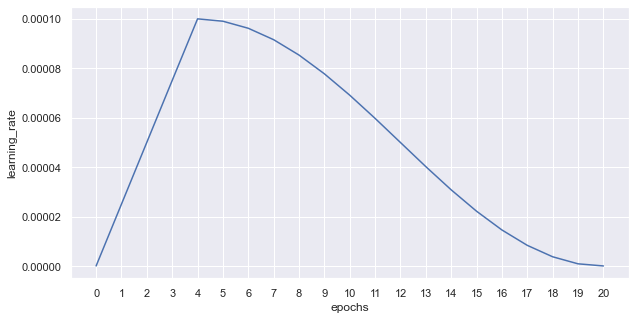

In [19]:
learning_rate = 1e-4
lr_start = 1e-7
lr_min = 1e-7
lr_max = learning_rate
n_cycles = 0.5
epochs_rampup = 4
epochs_sustain = 0
epochs = 20

y = [cosine_decay(x) for x in np.arange(0, epochs+1, 1)]

plt.figure(figsize=(10,5))
plt.plot(np.arange(0, epochs+1, 1), y)
plt.xlabel("epochs")
plt.ylabel("learning_rate")
plt.xticks(range(epochs+1))
plt.show()

In [22]:
model_training(
    model=EfficientNetB5,
    model_name='models/model16',
    weights='imagenet',
    dropout_rate=0.2,
    learning_rate=learning_rate,
    label_smoothing=0.4,
    n_splits=5,
    fold=1,
    schedule=cosine_decay,
    epochs=epochs
    )

Number of training images: 20691
Number of validation images: 5643

-------------- FOLD 1/5 --------------
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-07.
   1/1293 [..............................] - ETA: 47:03:18 - loss: 1.5421 - categorical_accuracy: 0.4375

#### Results

### ResNet50V2

In [ ]:
# model_training(
#     model=ResNet50V2,
#     model_name='models/modelx',
#     weights='imagenet',
#     dropout_rate=0.1,
#     learning_rate=learning_rate,
#     label_smoothing=0.1,
#     n_splits=5,
#     fold=1,
#     schedule=cosine_warmup,
#     epochs=epochs
#     )

### Xception

In [ ]:
# model_training(
#     model=Xception,
#     model_name='models/modelx',
#     weights='imagenet',
#     dropout_rate=0.1,
#     learning_rate=learning_rate,
#     label_smoothing=0.1,
#     n_splits=5,
#     fold=1,
#     schedule=cosine_warmup,
#     epochs=epochs
#     )

### InceptionV3

In [ ]:
# model_training(
#     model=InceptionV3,
#     model_name='models/modelx',
#     weights='imagenet',
#     dropout_rate=0.1,
#     learning_rate=learning_rate,
#     label_smoothing=0.1,
#     n_splits=5,
#     fold=1,
#     schedule=cosine_warmup,
#     epochs=epochs
#     )

#### Results

## Ensemble training

Introducing variety improves ensembling, so we specifically chose the best models ranging from input size, model and its complexity, and which fold of the dataset it trained on.

## Test-time Augmentation